# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
pd.set_option('display.max_columns', 500)

%matplotlib inline


df = pd.read_csv('data/hw2data.csv', index_col=0)


b) Set to be the y variable in the dataframe from a and X to be the remaining features.

In [16]:
y = df['y']
X = df.drop('y', 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

In [17]:

alphas = np.logspace(-5,0,1000)
scores = []   

#best_alpha = alphas[best_alpha_index]
train_errors=[]
test_errors=[]

for alpha in alphas:
    regr = Lasso(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train, y_train))
    test_errors.append(regr.score(X_test,y_test))

best_alpha_index = np.argmax(test_errors)
alpha_optim= alphas[best_alpha_index]

C:\Users\lucas\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

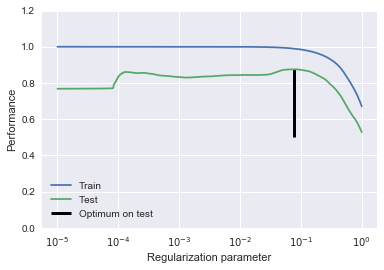

In [18]:
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')




e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

In [19]:
from IPython.display import Image
Image(filename='../images/lesso.png')

FileNotFoundError: [Errno 2] No such file or directory: '../images/lesso.png'

The above figure is contour plot of Lasso regression objective function. The elliptical contour plot in the figure represents sum of squared errors. The diamond shape in the middle indicates the constraint region. The optimal point is a point which is common point between ellipse and circle as well as gives a minimum value for the above function. There is a high probability that optimum point falls in the corner point of diamond region, which renders one of the variable(coefficient) zero.

To put it another way:
$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$

In the above equation, if $\lambda$ is sufficiently large, some of the coefficients are driven to zero, leading to a sparse model. 

In [ ]:

from sklearn.linear_model import Lasso
regr = Lasso(alpha=alpha_optim )
regr.fit(X_train,y_train)
regr.coef_

plt.figure(figsize=(16, 16))
df_coeffs = pd.DataFrame({'coeffs':regr.coef_, 'name':X.columns.values})
df_coeffs=df_coeffs.sort(['coeffs'])
df_coeffs[::-1].plot(x='name',y='coeffs',kind='bar', figsize=(14,14))

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

In [ ]:
from sklearn.model_selection import cross_val_score
regr = Lasso(alpha=alpha_optim)
scores = cross_val_score(regr, X, y, cv=5)

plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with Original Subsets lambda=' + str(alpha))
plt.bar(range(1,6),scores)
plt.show()
R_average = np.mean(scores)
print("Normal R^2 value is \n", R_average)

#Randomized
from sklearn.utils import shuffle

random_state = np.random.RandomState(0)

X_random, y_random = shuffle(X, y, random_state=random_state)
regr = Lasso(alpha=alpha_optim)
scores = cross_val_score(regr, X_random, y_random, cv=5)

plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with Randomized Subsets with lambda=' + str(alpha))
plt.bar(range(1,6),scores)
plt.show()
R_average = np.mean(scores)
print("Randomized R^2 value is \n", R_average)


This model works well with random subsets because the both R^2 of random subsets and original subsets agree with one another. 

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [ ]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs

alpha_best = alpha_optim

scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_best)


In [ ]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

In [ ]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))